# Import packages

In [1]:
from atgfe.GeneticFeatureEngineer import GeneticFeatureEngineer
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.metrics import mean_squared_error, make_scorer
from yellowbrick.regressor import ResidualsPlot, PredictionError
from lightgbm import LGBMRegressor
from yellowbrick.datasets import load_concrete

In [2]:
dataset = load_concrete(return_dataset=True)
df = dataset.to_dataframe()
df.head()

,cement,slag,ash,water,splast,coarse,fine,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075


In [3]:
target = 'strength'
X = df.drop(target, axis=1).copy()
numerical_features = X.columns.tolist()
Y = df.loc[:, target].copy()
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=77)

In [4]:
def display_residual_plot(model):
    visualizer = ResidualsPlot(model)
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)  
    visualizer.poof()  

In [5]:
def prediction_error_plot(model):
    visualizer = PredictionError(model)
    visualizer.fit(X_train, y_train)  
    visualizer.score(X_test, y_test)  
    visualizer.poof()     

In [6]:
def rmse(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [7]:
def score_model(model, X, y):
    evaluation_metric_scorer = make_scorer(rmse)
    scores = cross_val_score(estimator=model, X=X, y=y, cv=10, scoring=evaluation_metric_scorer, n_jobs=-1)
    scores_mean = scores.mean()
    score_std = scores.std()
    print('Mean of metric: {}, std: {}'.format(scores_mean, score_std))

In [8]:
def create_new_model():
    model = make_pipeline(StandardScaler(), LinearRegression(n_jobs=1))
    return model

# Using LightGBM

In [9]:
lgbm_model = LGBMRegressor(n_estimators=100, random_state=7)

In [10]:
score_model(lgbm_model, X, Y)

Mean of metric: 6.440673433553295, std: 2.133572203780573


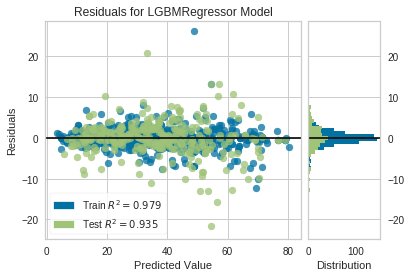

In [11]:
display_residual_plot(lgbm_model)

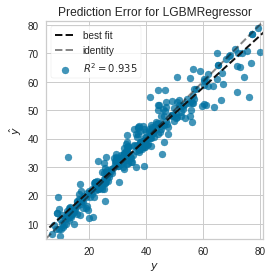

In [12]:
prediction_error_plot(lgbm_model)

# Using Logistic Regression

In [13]:
model = create_new_model()

In [14]:
score_model(model, X, Y)

Mean of metric: 11.13362671274308, std: 2.798781230056411


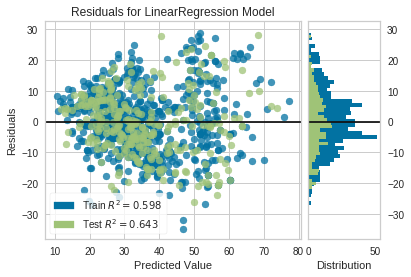

In [15]:
display_residual_plot(model)

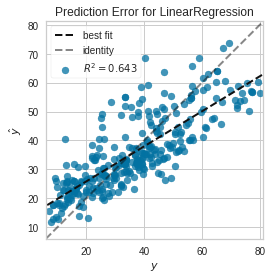

In [16]:
prediction_error_plot(model)

# Using ATgfe

In [17]:
model = create_new_model()

In [18]:
gfe = GeneticFeatureEngineer(model, x_train=X_train, y_train=y_train, numerical_features=numerical_features,
                             number_of_candidate_features=8,
                             number_of_interacting_features=4,
                             evaluation_metric=rmse, minimize_metric=True, verbose=True, cv=10,
                            fit_wo_original_columns=False)

2019-11-16 20:48:12,222:INFO: New Engineer created with the following parameters: 
2019-11-16 20:48:12,224:INFO: 
Model type: <class 'sklearn.pipeline.Pipeline'>
Numerical Features: ['cement', 'slag', 'ash', 'water', 'splast', 'coarse', 'fine', 'age']
Number of candidate features: 8
Number of interacting features: 4
Evaluation Metric: rmse
Minimize metric is True 


In [19]:
gfe.fit(population_size=2500, early_stopping_patience=3)

2019-11-16 20:48:12,807:INFO: Start of evolution 
2019-11-16 20:48:48,366:INFO:   Evaluated 2500 individuals 
2019-11-16 20:48:48,368:INFO: -- Generation 1 -- 
2019-11-16 20:49:18,705:INFO:   Evaluated 1511 individuals 
2019-11-16 20:49:18,713:INFO:   Min 7.279554275068725 
2019-11-16 20:49:18,714:INFO:   Max 1000000000000.0 
2019-11-16 20:49:18,715:INFO:   Avg 165560000006.78687 
2019-11-16 20:49:18,716:INFO:   Std 365876873275.35986 
2019-11-16 20:49:20,833:INFO: Generation: 1, validation scores: [6.67073701 8.00672303 7.43209391 8.04137648 8.49684397 7.11708123
 8.06466508 7.25874063 7.00600244 5.94404673], mean_score: 7.403831051472537 
2019-11-16 20:49:20,835:INFO: Generation: 1, best solution features: ['cement', 'slag', 'ash', 'water', 'splast', 'coarse', 'fine', 'age', '-ash*cement*coarse + water', 'coarse/age', 'fine - 1/age', 'ash/cement', 'coarse**2*splast**2', 'ash - coarse*slag/age', '(age + fine)*(ash + coarse)'] 
2019-11-16 20:49:20,836:INFO: -- Generation 2 -- 
2019-11-

# Apply GFE

In [20]:
X = gfe.transform(X)

In [21]:
X.head(20)

,cement,slag,ash,water,splast,coarse,fine,age,-ash*cement + water,cement/(age*splast + cement),(fine - slag)/fine,ash/cement,ash + cement + cement/age,slag/age,water/(age**2 + coarse),(age + fine)*(ash + coarse)
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,162.0,0.885246,1.000000,0.0,559.285714,0.000000,0.088816,732160.0
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,162.0,0.885246,1.000000,0.0,559.285714,0.000000,0.088091,742720.0
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,228.0,1.000000,0.760101,0.0,333.731481,0.527778,0.003088,805248.0
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,228.0,1.000000,0.760101,0.0,333.410959,0.390411,0.001700,893788.0
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,192.0,1.000000,0.839612,0.0,199.151667,0.367778,0.001470,1159893.2
5,266.0,114.0,0.0,228.0,0.0,932.0,670.0,90,228.0,1.000000,0.829851,0.0,268.955556,1.266667,0.025244,708320.0
6,380.0,95.0,0.0,228.0,0.0,932.0,594.0,365,228.0,1.000000,0.840067,0.0,381.041096,0.260274,0.001700,893788.0
7,380.0,95.0,0.0,228.0,0.0,932.0,594.0,28,228.0,1.000000,0.840067,0.0,393.571429,3.392857,0.132867,579704.0
8,266.0,114.0,0.0,228.0,0.0,932.0,670.0,28,228.0,1.000000,0.829851,0.0,275.500000,4.071429,0.132867,650536.0
9,475.0,0.0,0.0,228.0,0.0,932.0,594.0,28,228.0,1.000000,1.000000,0.0,491.964286,0.000000,0.132867,579704.0


In [22]:
model = create_new_model()

In [23]:
score_model(model, X, Y)

Mean of metric: 6.783229438900291, std: 1.777211133290342


In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=77)

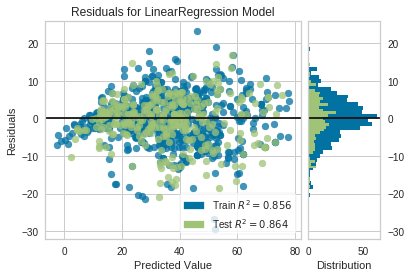

In [25]:
display_residual_plot(model)

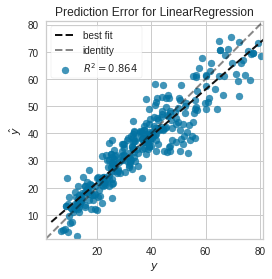

In [26]:
prediction_error_plot(model)

# Run ATgfe with operations and weights

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=77)
columns = X.columns.tolist()

In [28]:
gfe = GeneticFeatureEngineer(model, x_train=X_train, y_train=y_train, numerical_features=numerical_features,
                             number_of_candidate_features=8,
                             number_of_interacting_features=4,
                             evaluation_metric=rmse, minimize_metric=True, verbose=True, cv=10,
                            fit_wo_original_columns=False, enable_feature_transformation_operations=True, enable_weights=True)

2019-11-16 20:56:28,743:INFO: New Engineer created with the following parameters: 
2019-11-16 20:56:28,744:INFO: 
Model type: <class 'sklearn.pipeline.Pipeline'>
Numerical Features: ['cement', 'slag', 'ash', 'water', 'splast', 'coarse', 'fine', 'age']
Number of candidate features: 8
Number of interacting features: 4
Evaluation Metric: rmse
Minimize metric is True 


In [29]:
gfe.fit(population_size=2000, early_stopping_patience=10)

2019-11-16 20:56:29,228:INFO: Start of evolution 
2019-11-16 20:57:42,745:INFO:   Evaluated 2000 individuals 
2019-11-16 20:57:42,747:INFO: -- Generation 1 -- 
2019-11-16 20:58:57,462:INFO:   Evaluated 1225 individuals 
2019-11-16 20:58:57,471:INFO:   Min 5.956162973073118 
2019-11-16 20:58:57,472:INFO:   Max 100000000000.0 
2019-11-16 20:58:57,473:INFO:   Avg 8200000006.238389 
2019-11-16 20:58:57,473:INFO:   Std 27436472074.552315 
2019-11-16 20:58:59,732:INFO: Generation: 1, validation scores: [6.12028361 5.99663199 5.92045158 6.32361113 7.24532946 5.96923992
 6.2566362  6.2825575  5.71970472 4.94045317], mean_score: 6.0774899261620785 
2019-11-16 20:58:59,733:INFO: Generation: 1, best solution features: ['cement', 'slag', 'ash', 'water', 'splast', 'coarse', 'fine', 'age', '-ash*cement + water', 'cement/(age*splast + cement)', '(fine - slag)/fine', 'ash/cement', 'ash + cement + cement/age', 'slag/age', 'water/(age**2 + coarse)', '(age + fine)*(ash + coarse)', '0.84*cube(water) - 0.5

In [30]:
X = gfe.transform(X)

In [31]:
model = create_new_model()

In [32]:
score_model(model, X, Y)

Mean of metric: 6.68232542050302, std: 1.5063098519936189


In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=77)

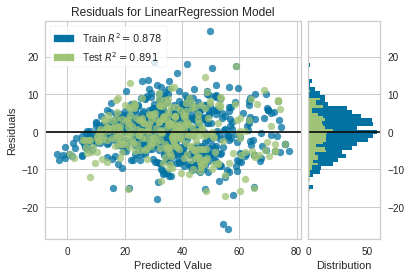

In [34]:
display_residual_plot(model)

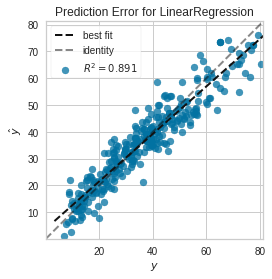

In [35]:
prediction_error_plot(model)